In [ ]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
from keras.utils.vis_utils import plot_model
from keras.models import load_model
np.random.seed(50)   
tf.random.set_seed(50)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]  
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

**# Transfer Learning: p5271 #**

In [ ]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Data/p5271_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Data/p5271MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(), 'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
        freqQAmpI_filt       C_filt
0        86444.183014  5713.739611
1        86444.358094  5713.748279
2        86442.647757  5713.750421
3        86419.380962  5713.758606
4        86414.552286  5713.772870
...               ...          ...
75994    81488.107323  5720.364457
75995    81375.846782  5720.365210
75996    81263.154871  5720.384980
75997    81137.502620  5720.393775
75998    80982.695515  5720.397332

[75999 rows x 2 columns]
Target Data:
              SS     V_filt
0      5.893849  10.577261
1      5.893360  10.282278
2      5.893242  10.050505
3      5.893039   9.903014
4      5.892528   9.945154
...         ...        ...
75994  5.850977   0.674248
75995  5.851531   0.653177
75996  5.852108   0.863880
75997  5.852526   0.716388
75998  5.852725   0.863880

[75999 rows x 2 columns]


In [ ]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (75699, 300, 2)
Target shape (SS), Y =  (75699,)
Target shape (V), Y =  (75699,)
After reshaping, X =  (75699, 600)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Training Data Percentage 
X_train = X_train[15200:53199]
Y_train_SS = Y_train_SS[15200:53199]
Y_train_V = Y_train_V[15200:53199]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 37789
Validation samples: 7570
Testing samples: 15140


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

Train on 37789 samples, validate on 7570 samples
Epoch 1/100
37408/37789 [============================>.] - ETA: 0s - loss: 0.0108 - dense_5_loss: 0.0074 - dense_6_loss: 0.0034

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.00804, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


37789/37789 [==============================] - 6s 167us/sample - loss: 0.0108 - dense_5_loss: 0.0074 - dense_6_loss: 0.0034 - val_loss: 0.0080 - val_dense_5_loss: 0.0070 - val_dense_6_loss: 0.0011
Epoch 2/100
37504/37789 [============================>.] - ETA: 0s - loss: 0.0047 - dense_5_loss: 0.0038 - dense_6_loss: 9.0803e-04
Epoch 2: val_loss improved from 0.00804 to 0.00575, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


37789/37789 [==============================] - 4s 114us/sample - loss: 0.0047 - dense_5_loss: 0.0038 - dense_6_loss: 9.0469e-04 - val_loss: 0.0058 - val_dense_5_loss: 0.0047 - val_dense_6_loss: 0.0011
Epoch 3/100
37600/37789 [============================>.] - ETA: 0s - loss: 0.0039 - dense_5_loss: 0.0031 - dense_6_loss: 7.8681e-04
Epoch 3: val_loss improved from 0.00575 to 0.00474, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


37789/37789 [==============================] - 4s 116us/sample - loss: 0.0039 - dense_5_loss: 0.0031 - dense_6_loss: 7.8725e-04 - val_loss: 0.0047 - val_dense_5_loss: 0.0041 - val_dense_6_loss: 6.5264e-04
Epoch 4/100
37184/37789 [============================>.] - ETA: 0s - loss: 0.0036 - dense_5_loss: 0.0029 - dense_6_loss: 7.4481e-04
Epoch 4: val_loss did not improve from 0.00474
37789/37789 [==============================] - 3s 80us/sample - loss: 0.0036 - dense_5_loss: 0.0029 - dense_6_loss: 7.4041e-04 - val_loss: 0.0053 - val_dense_5_loss: 0.0044 - val_dense_6_loss: 8.9364e-04
Epoch 5/100
37536/37789 [============================>.] - ETA: 0s - loss: 0.0033 - dense_5_loss: 0.0026 - dense_6_loss: 6.8746e-04
Epoch 5: val_loss did not improve from 0.00474
37789/37789 [==============================] - 3s 81us/sample - loss: 0.0033 - dense_5_loss: 0.0026 - dense_6_loss: 6.8495e-04 - val_loss: 0.0055 - val_dense_5_loss: 0.0039 - val_dense_6_loss: 0.0016
Epoch 6/100
37664/37789 [========

37789/37789 [==============================] - 4s 117us/sample - loss: 0.0030 - dense_5_loss: 0.0023 - dense_6_loss: 6.4707e-04 - val_loss: 0.0041 - val_dense_5_loss: 0.0036 - val_dense_6_loss: 5.4183e-04
Epoch 8/100
37184/37789 [============================>.] - ETA: 0s - loss: 0.0029 - dense_5_loss: 0.0023 - dense_6_loss: 5.9817e-04
Epoch 8: val_loss did not improve from 0.00410
37789/37789 [==============================] - 3s 81us/sample - loss: 0.0029 - dense_5_loss: 0.0023 - dense_6_loss: 6.0074e-04 - val_loss: 0.0043 - val_dense_5_loss: 0.0037 - val_dense_6_loss: 5.7095e-04
Epoch 9/100
37344/37789 [============================>.] - ETA: 0s - loss: 0.0028 - dense_5_loss: 0.0023 - dense_6_loss: 5.8698e-04
Epoch 9: val_loss improved from 0.00410 to 0.00400, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


37789/37789 [==============================] - 5s 120us/sample - loss: 0.0028 - dense_5_loss: 0.0023 - dense_6_loss: 5.8686e-04 - val_loss: 0.0040 - val_dense_5_loss: 0.0034 - val_dense_6_loss: 6.4274e-04
Epoch 10/100
37760/37789 [============================>.] - ETA: 0s - loss: 0.0027 - dense_5_loss: 0.0022 - dense_6_loss: 5.6632e-04
Epoch 10: val_loss did not improve from 0.00400
37789/37789 [==============================] - 3s 80us/sample - loss: 0.0027 - dense_5_loss: 0.0022 - dense_6_loss: 5.6610e-04 - val_loss: 0.0041 - val_dense_5_loss: 0.0035 - val_dense_6_loss: 5.5836e-04
Epoch 11/100
37312/37789 [============================>.] - ETA: 0s - loss: 0.0027 - dense_5_loss: 0.0021 - dense_6_loss: 5.3206e-04
Epoch 11: val_loss did not improve from 0.00400
37789/37789 [==============================] - 3s 82us/sample - loss: 0.0027 - dense_5_loss: 0.0021 - dense_6_loss: 5.2995e-04 - val_loss: 0.0043 - val_dense_5_loss: 0.0034 - val_dense_6_loss: 8.1348e-04
Epoch 12/100
37632/37789 

37789/37789 [==============================] - 5s 125us/sample - loss: 0.0024 - dense_5_loss: 0.0019 - dense_6_loss: 5.0669e-04 - val_loss: 0.0035 - val_dense_5_loss: 0.0030 - val_dense_6_loss: 4.9689e-04
Epoch 19/100
37344/37789 [============================>.] - ETA: 0s - loss: 0.0023 - dense_5_loss: 0.0018 - dense_6_loss: 4.7695e-04
Epoch 19: val_loss did not improve from 0.00352
37789/37789 [==============================] - 3s 80us/sample - loss: 0.0023 - dense_5_loss: 0.0018 - dense_6_loss: 4.7387e-04 - val_loss: 0.0036 - val_dense_5_loss: 0.0031 - val_dense_6_loss: 4.8734e-04
Epoch 20/100
37152/37789 [============================>.] - ETA: 0s - loss: 0.0023 - dense_5_loss: 0.0018 - dense_6_loss: 4.9028e-04
Epoch 20: val_loss did not improve from 0.00352
37789/37789 [==============================] - 3s 81us/sample - loss: 0.0023 - dense_5_loss: 0.0018 - dense_6_loss: 4.8718e-04 - val_loss: 0.0050 - val_dense_5_loss: 0.0046 - val_dense_6_loss: 4.4997e-04
Epoch 21/100
37184/37789 

37789/37789 [==============================] - 4s 115us/sample - loss: 0.0020 - dense_5_loss: 0.0016 - dense_6_loss: 4.5321e-04 - val_loss: 0.0035 - val_dense_5_loss: 0.0030 - val_dense_6_loss: 4.6146e-04
Epoch 34/100
37664/37789 [============================>.] - ETA: 0s - loss: 0.0020 - dense_5_loss: 0.0015 - dense_6_loss: 4.8284e-04
Epoch 34: val_loss did not improve from 0.00350
37789/37789 [==============================] - 3s 83us/sample - loss: 0.0020 - dense_5_loss: 0.0015 - dense_6_loss: 4.8234e-04 - val_loss: 0.0037 - val_dense_5_loss: 0.0032 - val_dense_6_loss: 5.6967e-04
Epoch 35/100
37280/37789 [============================>.] - ETA: 0s - loss: 0.0019 - dense_5_loss: 0.0015 - dense_6_loss: 4.4094e-04
Epoch 35: val_loss did not improve from 0.00350
37789/37789 [==============================] - 3s 81us/sample - loss: 0.0019 - dense_5_loss: 0.0015 - dense_6_loss: 4.4048e-04 - val_loss: 0.0037 - val_dense_5_loss: 0.0033 - val_dense_6_loss: 4.2611e-04
Epoch 36/100
37664/37789 

37789/37789 [==============================] - 4s 118us/sample - loss: 0.0019 - dense_5_loss: 0.0015 - dense_6_loss: 4.4143e-04 - val_loss: 0.0033 - val_dense_5_loss: 0.0029 - val_dense_6_loss: 4.1458e-04
Epoch 37/100
37600/37789 [============================>.] - ETA: 0s - loss: 0.0019 - dense_5_loss: 0.0015 - dense_6_loss: 4.4549e-04
Epoch 37: val_loss did not improve from 0.00328
37789/37789 [==============================] - 3s 82us/sample - loss: 0.0019 - dense_5_loss: 0.0015 - dense_6_loss: 4.4594e-04 - val_loss: 0.0034 - val_dense_5_loss: 0.0029 - val_dense_6_loss: 4.4443e-04
Epoch 38/100
37248/37789 [============================>.] - ETA: 0s - loss: 0.0019 - dense_5_loss: 0.0015 - dense_6_loss: 4.5110e-04
Epoch 38: val_loss did not improve from 0.00328
37789/37789 [==============================] - 3s 80us/sample - loss: 0.0019 - dense_5_loss: 0.0014 - dense_6_loss: 4.5085e-04 - val_loss: 0.0035 - val_dense_5_loss: 0.0031 - val_dense_6_loss: 4.2521e-04
Epoch 39/100
37152/37789 

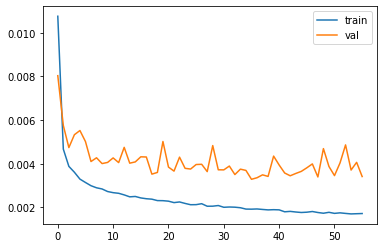

---Training time: 187.31055617 seconds ---


In [ ]:
# Load the pretrained model and re-fit
model = load_model('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/DD_Transfer_model_70_10_20.h5')

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3))
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')  
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  #Saves best model so far
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)
end_time = time.time()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

print("---Training time: %0.8f seconds ---" % (end_time - start_time))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dense_1[0][0]']                
                                                                                              

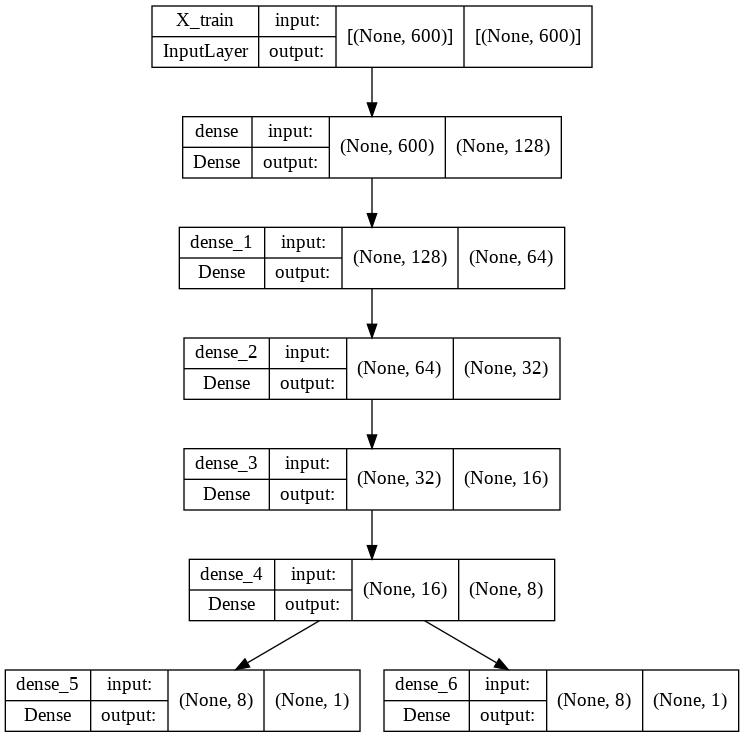

In [ ]:
# Model Summary
print(model.summary())
plot_model(model, show_shapes=True)

In [ ]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results 
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.95382, Train (V) - 0.89787
R2 scores: Validation (SS) - 0.92797, Validation (V) - 0.89714
R2 scores: Testing (SS) - 0.74788, Testing (V) - 0.78426
RMSE scores: Train (SS) - 0.03529, Train (V) - 0.01946
RMSE scores: Validation (SS) - 0.05330, Validation (V) - 0.02386
RMSE scores: Testing (SS) - 0.10808, Testing (V) - 0.03962


In [ ]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

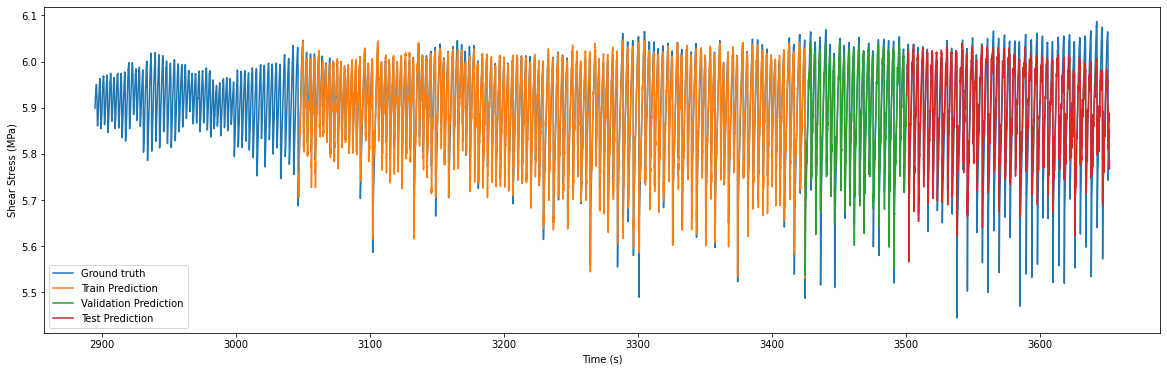

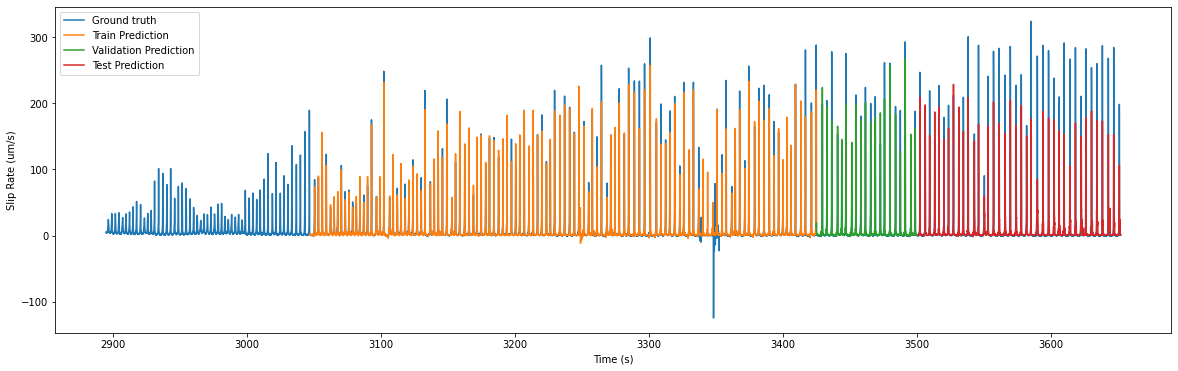

In [ ]:
# Overall plot: SS & V 
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[15200:53199] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

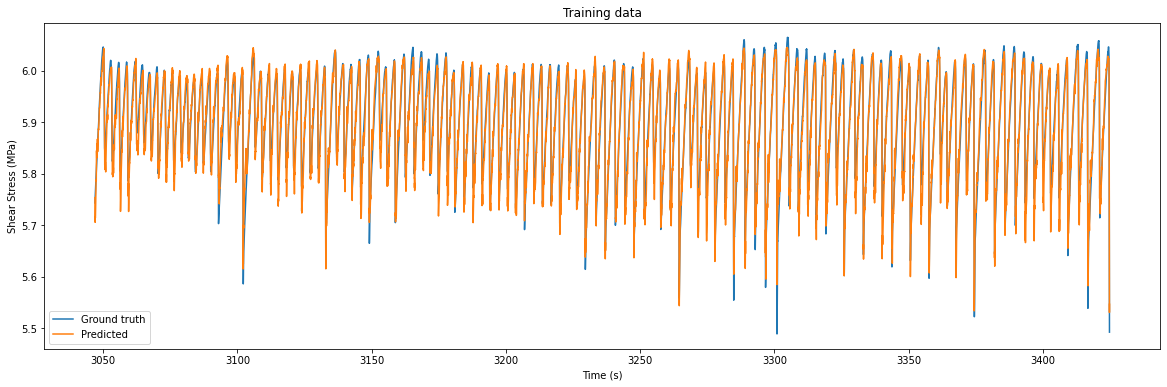

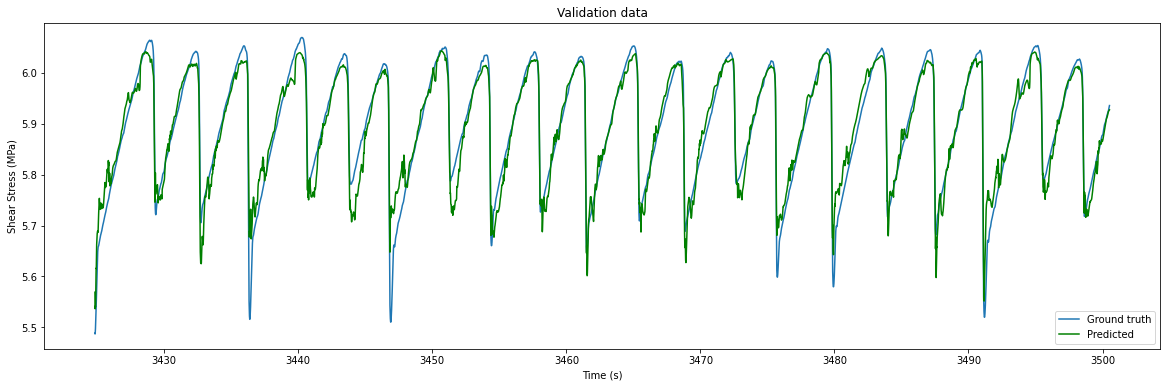

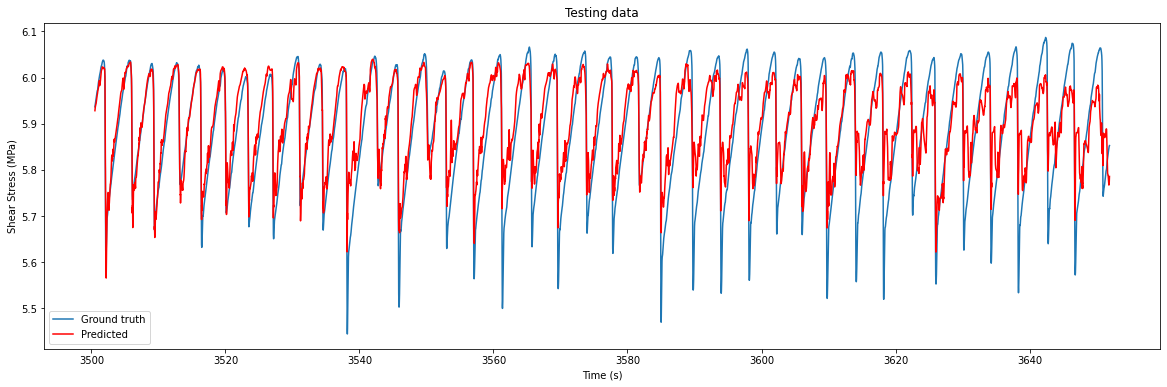

In [ ]:
# # Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

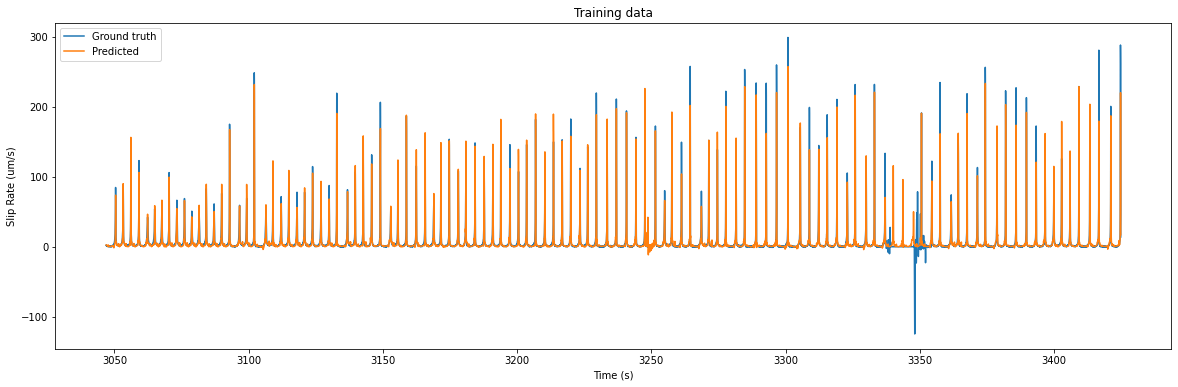

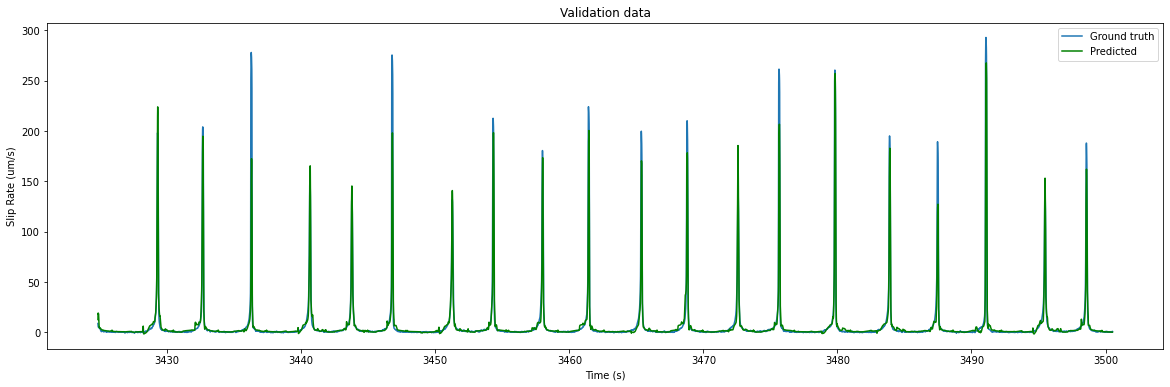

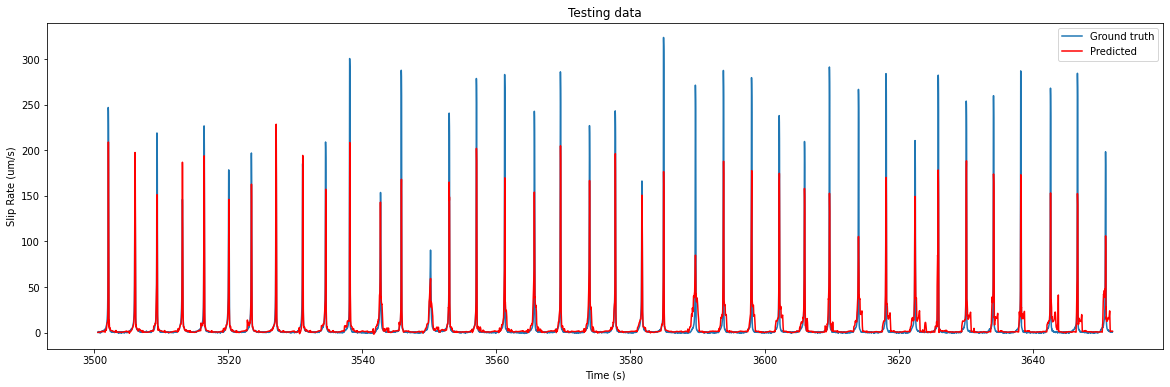

In [ ]:
# # Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')